In [1]:
!pip install tensorflow-gpu


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!nvidia-smi

Fri Dec  9 17:50:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.47       Driver Version: 526.47       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   36C    P8    N/A /  N/A |   2686MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model
from keras.optimizers import SGD,Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow_addons as tfa

In [4]:
image_size = (224,224)
batch_size = 32

In [5]:
train_ds = image_dataset_from_directory('Dataset',
                                           subset='training',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

val_ds = image_dataset_from_directory('Dataset',
                                           subset='validation',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

Found 9466 files belonging to 8 classes.
Using 7573 files for training.
Found 9466 files belonging to 8 classes.
Using 1893 files for validation.


In [6]:
class_names = train_ds.class_names

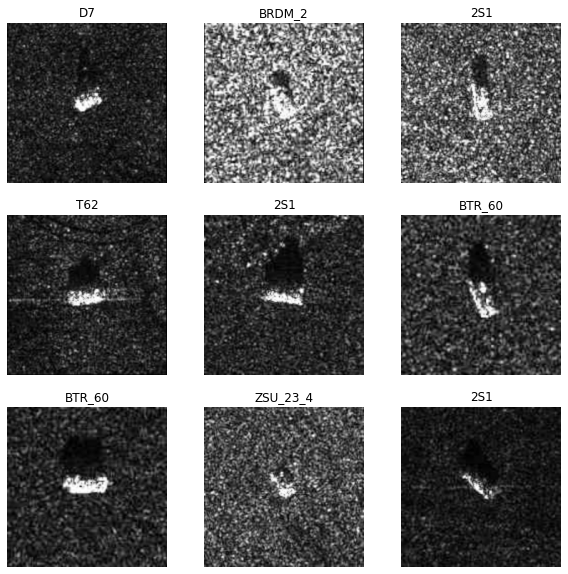

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [10]:
num_classes=8

metrics=[keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'), 
            keras.metrics.SpecificityAtSensitivity(0.5, name='specificity_at_sensitivity'),
            keras.metrics.SensitivityAtSpecificity(0.5, name='sensitivity_at_specificity'),
            keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
            ]
# metrics = [
#       keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
# ]

In [11]:
# efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size + (3,)))

In [11]:
import keras_model

In [12]:
efficientnet = keras_model.EfficientNetB0(include_top=False, input_shape=(image_size + (3,)))

In [13]:
for layer in efficientnet.layers:
    layer.trainable = False

In [14]:
model= Sequential()
model.add(efficientnet) 
# model.add(Flatten()) 

#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________


In [15]:
model.output_shape

(None, 7, 7, 1280)

In [16]:
model.add(tf.keras.layers.Conv2D(32,(1,1),activation='relu'))
model.add(tf.keras.layers.Conv2D(32,(1,1),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(Dense(num_classes,activation=('softmax')))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          40992     
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 8)                 2312      
                                                        

In [18]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)

In [19]:
history = model.fit(train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25
237/237 [==============================] - 55s 125ms/step - loss: 0.4601 - precision: 0.9488 - recall: 0.7688 - specificity_at_sensitivity: 0.9995 - sensitivity_at_specificity: 0.9993 - categorical_accuracy: 0.8518 - val_loss: 0.1015 - val_precision: 0.9739 - val_recall: 0.9636 - val_specificity_at_sensitivity: 1.0000 - val_sensitivity_at_specificity: 1.0000 - val_categorical_accuracy: 0.9689
Epoch 2/25
237/237 [==============================] - 20s 86ms/step - loss: 0.0832 - precision: 0.9745 - recall: 0.9676 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 0.9999 - categorical_accuracy: 0.9713 - val_loss: 0.0403 - val_precision: 0.9854 - val_recall: 0.9841 - val_specificity_at_sensitivity: 1.0000 - val_sensitivity_at_specificity: 1.0000 - val_categorical_accuracy: 0.9854
Epoch 3/25
237/237 [==============================] - 20s 84ms/step - loss: 0.0487 - precision: 0.9848 - recall: 0.9822 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 

Epoch 16/25
237/237 [==============================] - 20s 85ms/step - loss: 0.0183 - precision: 0.9942 - recall: 0.9941 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 0.9996 - categorical_accuracy: 0.9942 - val_loss: 0.0259 - val_precision: 0.9914 - val_recall: 0.9914 - val_specificity_at_sensitivity: 1.0000 - val_sensitivity_at_specificity: 1.0000 - val_categorical_accuracy: 0.9914
Epoch 17/25
237/237 [==============================] - 20s 85ms/step - loss: 0.0091 - precision: 0.9972 - recall: 0.9971 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 0.9999 - categorical_accuracy: 0.9971 - val_loss: 0.0089 - val_precision: 0.9980 - val_recall: 0.9980 - val_specificity_at_sensitivity: 1.0000 - val_sensitivity_at_specificity: 1.0000 - val_categorical_accuracy: 0.9980
Epoch 18/25
237/237 [==============================] - 20s 84ms/step - loss: 0.0119 - precision: 0.9968 - recall: 0.9968 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity

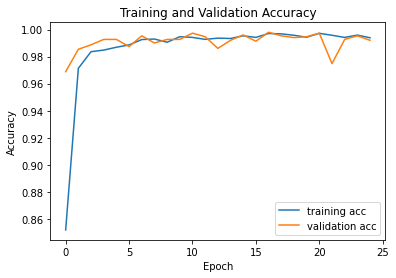

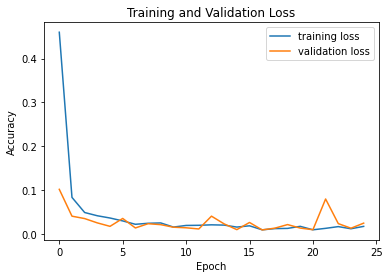

In [20]:
# plot the accuracy
plt.plot(history.history['categorical_accuracy'], label='training acc')
plt.plot(history.history['val_categorical_accuracy'], label='validation acc')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')
 
# plot the loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

In [21]:
test_score = model.evaluate(test_ds)
print("Accuracy: {:.2f}%".format(test_score[1] * 100))
print("Loss: ",test_score[0])

12/12 [==============================] - 1s 82ms/step - loss: 0.0486 - precision: 0.9844 - recall: 0.9844 - specificity_at_sensitivity: 0.9996 - sensitivity_at_specificity: 0.9974 - categorical_accuracy: 0.9844
Accuracy: 98.44%
Loss:  0.048648685216903687


In [22]:
def plot_cm(model, data):
    y_true = []
    y_pred = []
    for x,y in data:
        y= tf.argmax(y,axis=1)
        y_true.append(y)
        y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
    y_pred = tf.concat(y_pred, axis=0)
    y_true = tf.concat(y_true, axis=0)

    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(cm,cmap='binary', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10},
        cbar = False);
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    plt.show()

1/1 [==============================] - 0s 31ms/step


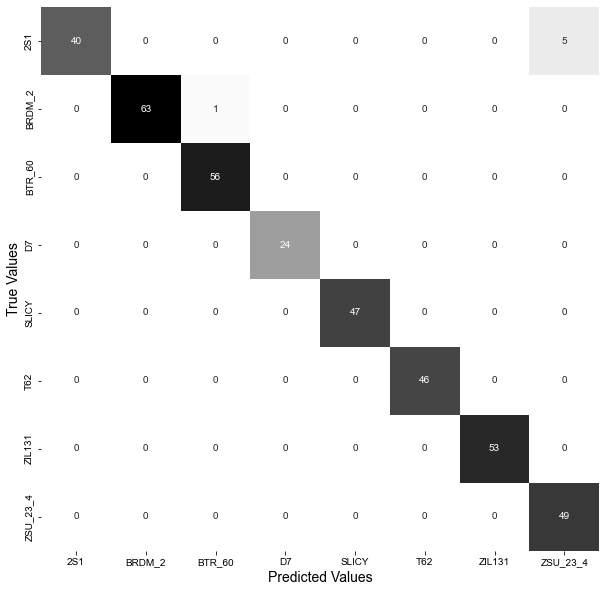

In [23]:
plot_cm(model,test_ds)

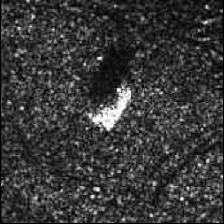

In [24]:
image = keras.utils.load_img(
    path="DATASET/T62/HB14941.jpg",
    color_mode='grayscale',
    target_size=(224,224)
)

image_array = keras.utils.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)

image

In [25]:
def predict_model(model):
    predictions = model.predict(image_array)
    score = tf.nn.softmax(predictions[0])
    return(
    "This image most likely belongs to {}"
    .format(class_names[np.argmax(score)]))

In [26]:
predict_model(model)

1/1 [==============================] - 1s 1s/step


'This image most likely belongs to T62'

In [ ]:
plt.show()
# Save the model
try: {
    model.save('EfficientNetB0_model2.h5')
}
except:{
    
}


In [ ]:
import tensorflow as tf

In [ ]:
tf.config.experimental.list_physical_devices()

In [ ]:
import keras_model

In [ ]:
ebb = keras_model.EfficientNetB0(include_top=False, input_shape=(image_size + (3,)))

In [ ]:
ebb.summary()